In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
device = torch.device("cuda")
device

device(type='cuda')

In [3]:
class MNISTDataset(Dataset):
    def __init__(self, is_train:bool=True):
        self.is_train = is_train
        if self.is_train:
            self.data_path = "/kaggle/input/digit-recognizer/train.csv"
        else:
            self.data_path = "/kaggle/input/digit-recognizer/test.csv"
        self.image = None
        self.label = None
        df = pd.read_csv(self.data_path)
        if self.is_train:
            self.label = df["label"].to_numpy().reshape(-1, 1)
            df = df.drop(columns='label')
        self.image = df.to_numpy().reshape(-1, 1, 28, 28) / 255
 
    def __len__(self):
        return len(self.image)
    
    def __getitem__(self, index):
        image = torch.FloatTensor(self.image[index])
        if self.is_train:
            label = torch.zeros(10, dtype=torch.float)
            label[int(self.label[index])] = 1.0
            return image, label
        else:
            return image
    
train_datasets = MNISTDataset(is_train=True)
train_dataloader = DataLoader(train_datasets, batch_size=100, shuffle=True)

test_datasets = MNISTDataset(is_train=False)
test_dataloader = DataLoader(test_datasets, batch_size=100, shuffle=False)

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.seq1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.seq2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.seq3 = nn.Sequential(
            nn.Linear(7*7*64, 32, bias=True),
            nn.ELU(inplace=True),
            nn.Linear(32, 10, bias=True),
            nn.ELU()
        )
        
    def forward(self, x):
        x = self.seq1(x)
        x = self.seq2(x)
        x = x.view(x.size(0), -1)
        x = self.seq3(x)
        return x
    
model = SimpleCNN()
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
history = []

EPOCH = 100

for epoch in range(EPOCH):
    loss_tmp = []
    for i, (image, label) in enumerate(train_dataloader):
        image, label = image.to(device), label.to(device)
        y_pred = model(image)
        loss = criterion(y_pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_tmp.append(loss.item())
    history.append(np.mean(loss_tmp))
    print(f"\rEPOCH: [{epoch+1}/{EPOCH}], LOSS: {history[-1]:1.6f}", end="")

EPOCH: [100/100], LOSS: 0.000055

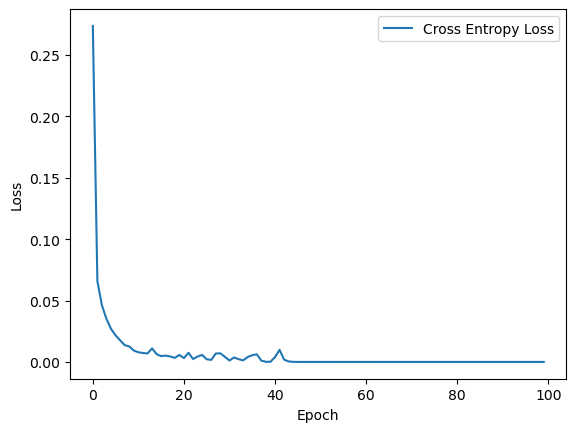

In [6]:
plt.plot(history, label="Cross Entropy Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [7]:
result = []
for i, image in enumerate(test_dataloader):
    image = image.to(device)
    y_pred = model(image)
    label_pred = torch.argmax(y_pred, dim=1)
    result.extend(label_pred.cpu().tolist())

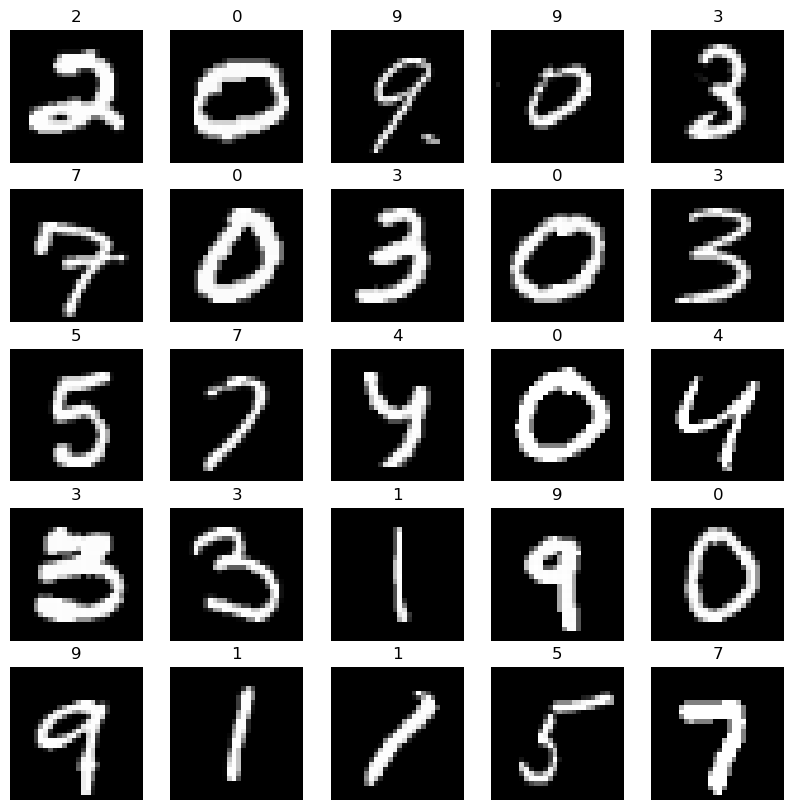

In [8]:
fig, axes = plt.subplots(5, 5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        idx = 5 * i + j
        axes[i][j].imshow(test_datasets[idx][0], cmap='gray')
        axes[i][j].set_title(result[idx])
        axes[i][j].axis('off')

plt.show()

# Nirmal 

In [9]:
# Sample
sample = pd.read_csv("/kaggle/input/digit-recognizer/sample_submission.csv")
sample['Label'] = result
sample.to_csv('/kaggle/working/submission.csv', index=False)

In [10]:
sample

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
